In [1]:
import numpy as np 
import cv2
import random
import glob
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import string
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import joblib
import pickle

In [2]:
# Load and preprocess data
training_dir = "fruits-360-original/Training"
testing_dir = "fruits-360-original/Test"
validation_dir = "fruits-360-original/Validation"

In [7]:
# Resizing images to 100x100 and preparing training data
image_size = (100, 100)
train_labels = []
train_data = []

for fruit_dir in os.listdir(training_dir):
    fruit_path = os.path.join(training_dir, fruit_dir)
    if os.path.isdir(fruit_path):
        for img_name in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, image_size)
                train_data.append(img_resized.flatten())
                train_labels.append(fruit_dir)

In [9]:
# Resizing images to 100x100 and preparing testing data
test_labels = []
test_data = []

for fruit_dir in os.listdir(testing_dir):
    fruit_path = os.path.join(testing_dir, fruit_dir)
    if os.path.isdir(fruit_path):
        for img_name in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, image_size)
                test_data.append(img_resized.flatten())
                test_labels.append(fruit_dir)

In [21]:
# Convert to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [ ]:
# Perform PCA for 2D visualization
pca_2d = PCA(n_components=2)
data_2d = pca_2d.fit_transform(train_data)

In [ ]:
# Perform PCA for 3D visualization
pca_3d = PCA(n_components=3)
data_3d = pca_3d.fit_transform(train_data)

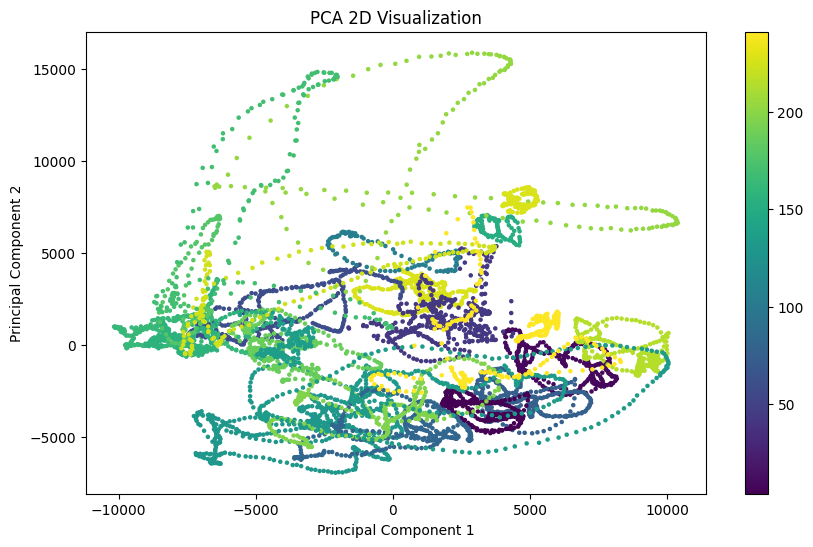

In [ ]:
# 2D PCA visualization
plt.figure(figsize=(10, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=[hash(label) % 256 for label in train_labels], cmap='viridis', s=5)
plt.colorbar()
plt.title("PCA 2D Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

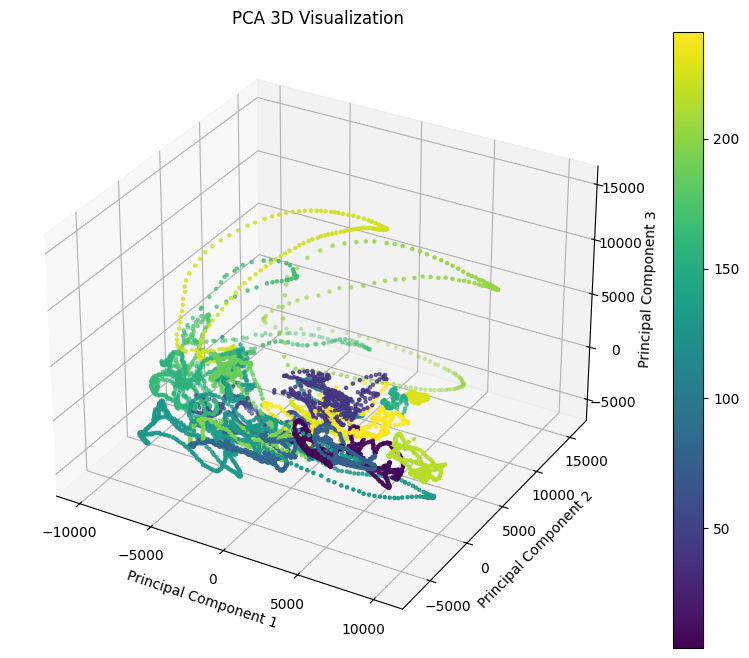

In [13]:
# 3D PCA visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=[hash(label) % 256 for label in train_labels], cmap='viridis', s=5)
plt.colorbar(sc)
ax.set_title("PCA 3D Visualization")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()

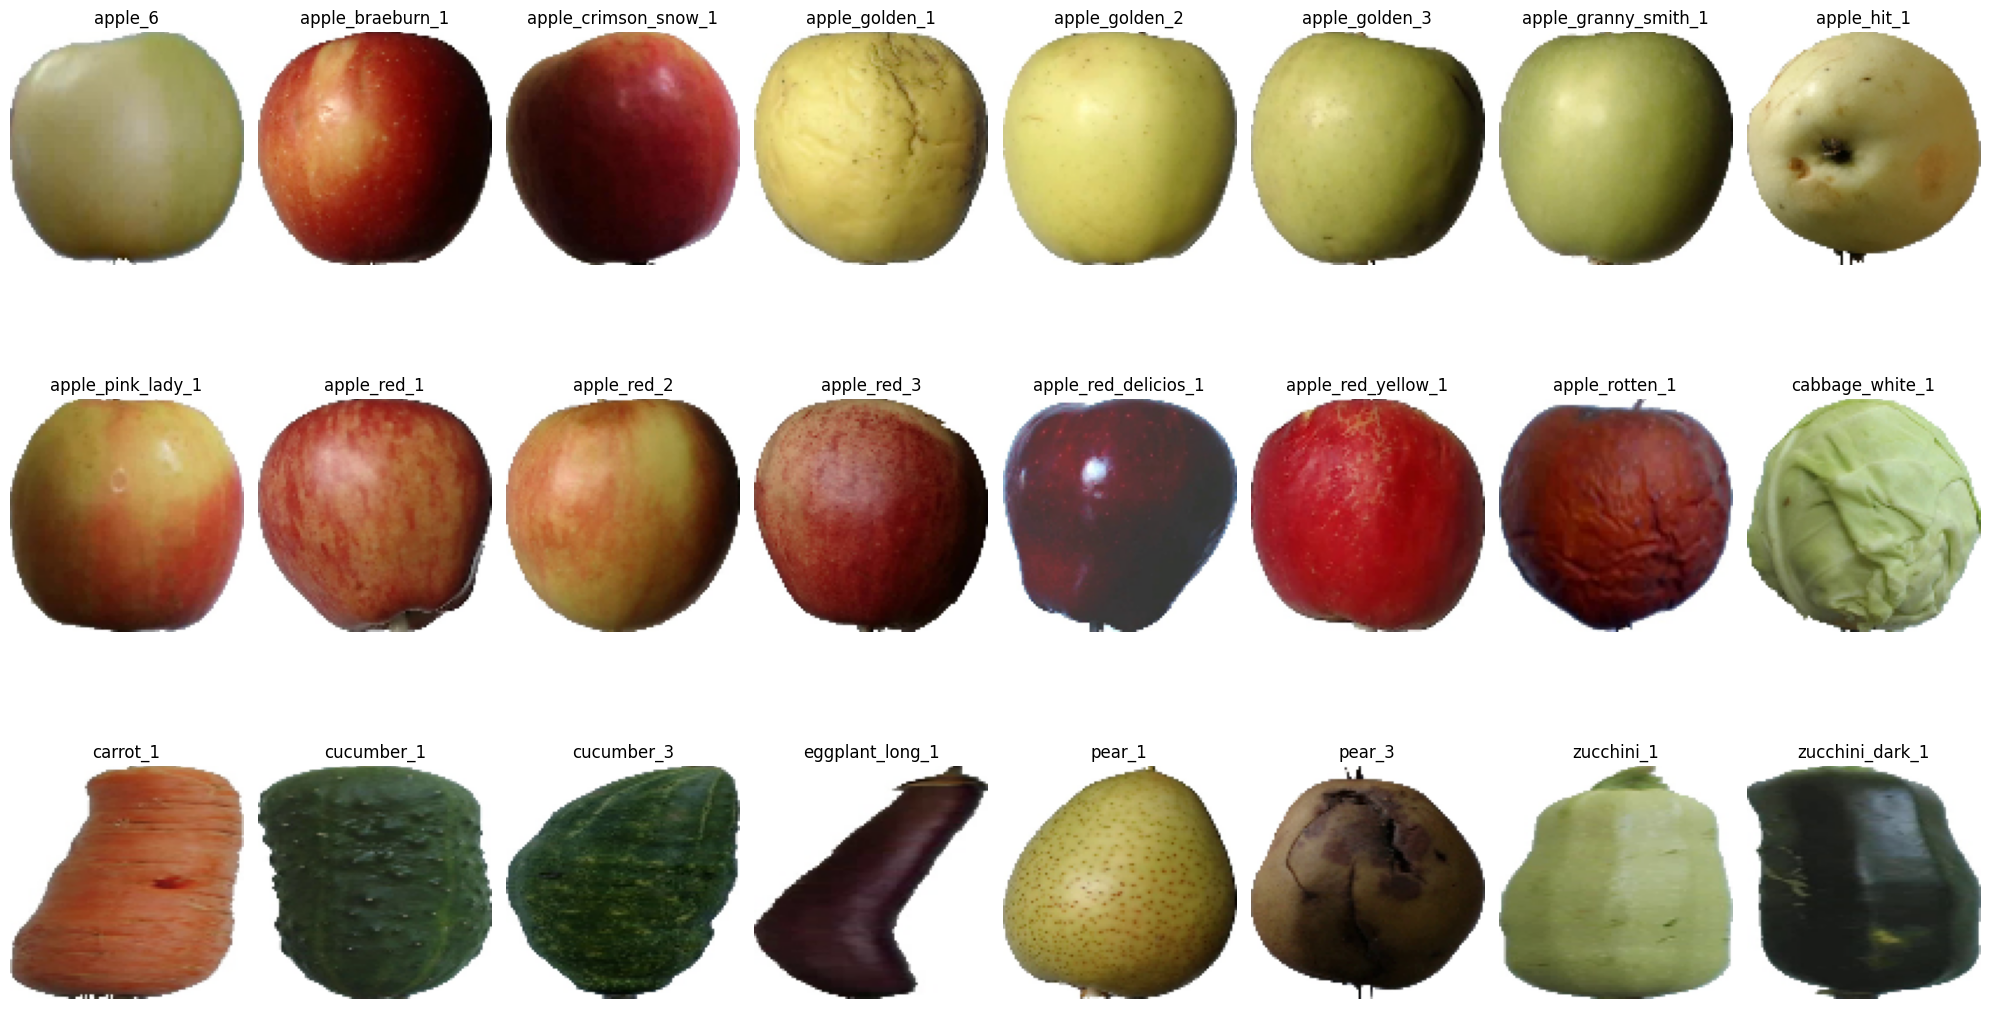

In [ ]:
# Visualize one image per class
unique_labels = np.unique(train_labels)
num_cols = 8
num_rows = int(np.ceil(len(unique_labels) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

for i, label in enumerate(unique_labels):
    row, col = divmod(i, num_cols)
    class_indices = np.where(train_labels == label)[0]
    img = train_data[class_indices[0]].reshape(image_size + (3,))
    axs[row, col].imshow(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')
    axs[row, col].set_title(label)

# Hide unused subplots
for i in range(len(unique_labels), num_rows * num_cols):
    row, col = divmod(i, num_cols)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Encode labels to numeric values
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [27]:
# Normalize data using StandardScaler
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [29]:
# Initialize results dictionary
results_summary = {}
confusion_matrices = {}

In [11]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators: Int = 100, )
print("Training Random Forest...")
rf_clf.fit(train_data, train_labels_encoded)
y_pred_rf = rf_clf.predict(test_data)

# Metrics for Random Forest
rf_report = classification_report(test_labels_encoded, y_pred_rf, output_dict=True, target_names=label_encoder.classes_)
results_summary["Random Forest"] = {
    "precision": np.mean([v["precision"] for k, v in rf_report.items() if k != "accuracy"]),
    "recall": np.mean([v["recall"] for k, v in rf_report.items() if k != "accuracy"]),
    "f1-score": np.mean([v["f1-score"] for k, v in rf_report.items() if k != "accuracy"]),
}
confusion_matrices["Random Forest"] = confusion_matrix(test_labels_encoded, y_pred_rf)

Training Random Forest...


In [12]:
# K-Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier()
print("Training K-Nearest Neighbors...")
knn_clf.fit(train_data, train_labels_encoded)
y_pred_knn = knn_clf.predict(test_data)

# Metrics for KNN
knn_report = classification_report(test_labels_encoded, y_pred_knn, output_dict=True, target_names=label_encoder.classes_)
results_summary["K-Nearest Neighbors"] = {
    "precision": np.mean([v["precision"] for k, v in knn_report.items() if k != "accuracy"]),
    "recall": np.mean([v["recall"] for k, v in knn_report.items() if k != "accuracy"]),
    "f1-score": np.mean([v["f1-score"] for k, v in knn_report.items() if k != "accuracy"]),
}
confusion_matrices["K-Nearest Neighbors"] = confusion_matrix(test_labels_encoded, y_pred_knn)


Training K-Nearest Neighbors...


In [13]:
# XGBoost Classifier
xgb_clf = XGBClassifier()
print("Training XGBoost...")
xgb_clf.fit(train_data, train_labels_encoded)
y_pred_xgb = xgb_clf.predict(test_data)

# Metrics for XGBoost
xgb_report = classification_report(test_labels_encoded, y_pred_xgb, output_dict=True, target_names=label_encoder.classes_)
results_summary["XGBoost"] = {
    "precision": np.mean([v["precision"] for k, v in xgb_report.items() if k != "accuracy"]),
    "recall": np.mean([v["recall"] for k, v in xgb_report.items() if k != "accuracy"]),
    "f1-score": np.mean([v["f1-score"] for k, v in xgb_report.items() if k != "accuracy"]),
}
confusion_matrices["XGBoost"] = confusion_matrix(test_labels_encoded, y_pred_xgb)


Training XGBoost...


In [14]:
# AdaBoost Classifier
ada_clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
print("Training AdaBoost...")

ada_clf.fit(train_data, train_labels_encoded)
y_pred_ada = ada_clf.predict(test_data)

# Metrics for AdaBoost
ada_report = classification_report(test_labels_encoded, y_pred_ada, output_dict=True, target_names=label_encoder.classes_)
results_summary["AdaBoost"] = {
    "precision": np.mean([v["precision"] for k, v in ada_report.items() if k != "accuracy"]),
    "recall": np.mean([v["recall"] for k, v in ada_report.items() if k != "accuracy"]),
    "f1-score": np.mean([v["f1-score"] for k, v in ada_report.items() if k != "accuracy"]),
}
confusion_matrices["AdaBoost"] = confusion_matrix(test_labels_encoded, y_pred_ada)


Training AdaBoost...


c:\Users\90544\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\90544\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\90544\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\90544\AppData\

In [16]:
# Save models
joblib.dump(rf_clf, 'random_forest_model.pkl')
joblib.dump(knn_clf, 'knn_model.pkl')
joblib.dump(xgb_clf, 'xgboost_model.pkl')
joblib.dump(ada_clf, 'adaboost_model.pkl')

['adaboost_model.pkl']

In [17]:
# Summary table
summary_df = pd.DataFrame.from_dict(results_summary, orient="index")
print("\nSummary Table:")
print(summary_df)


Summary Table:
                     precision    recall  f1-score
Random Forest         1.000000  1.000000  1.000000
K-Nearest Neighbors   1.000000  1.000000  1.000000
XGBoost               0.999729  0.999727  0.999727
AdaBoost              0.523899  0.413149  0.400851


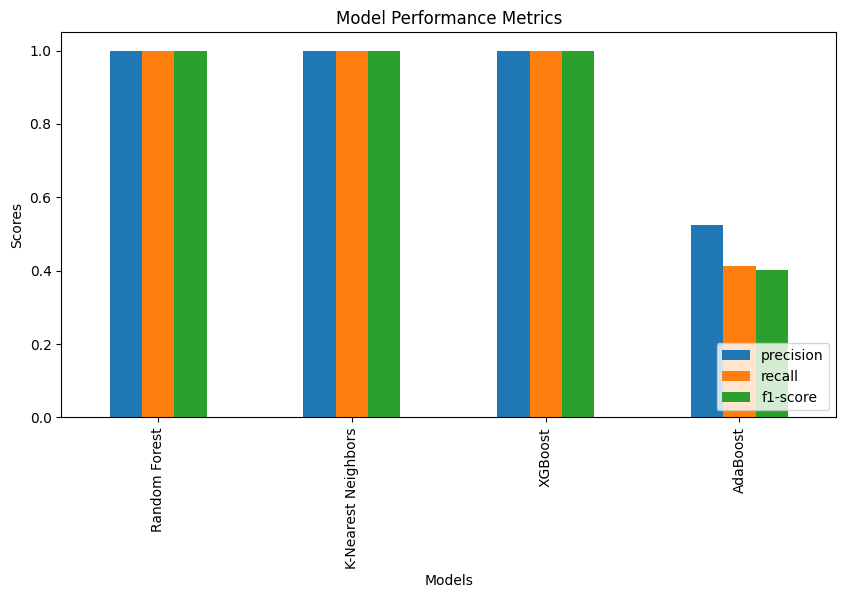

In [35]:
# Plot bar chart for precision, recall, and f1-score
summary_df.plot(kind="bar", figsize=(10, 5), title="Model Performance Metrics")
plt.ylabel("Scores")
plt.xlabel("Models")
plt.legend(loc="lower right")
plt.show()

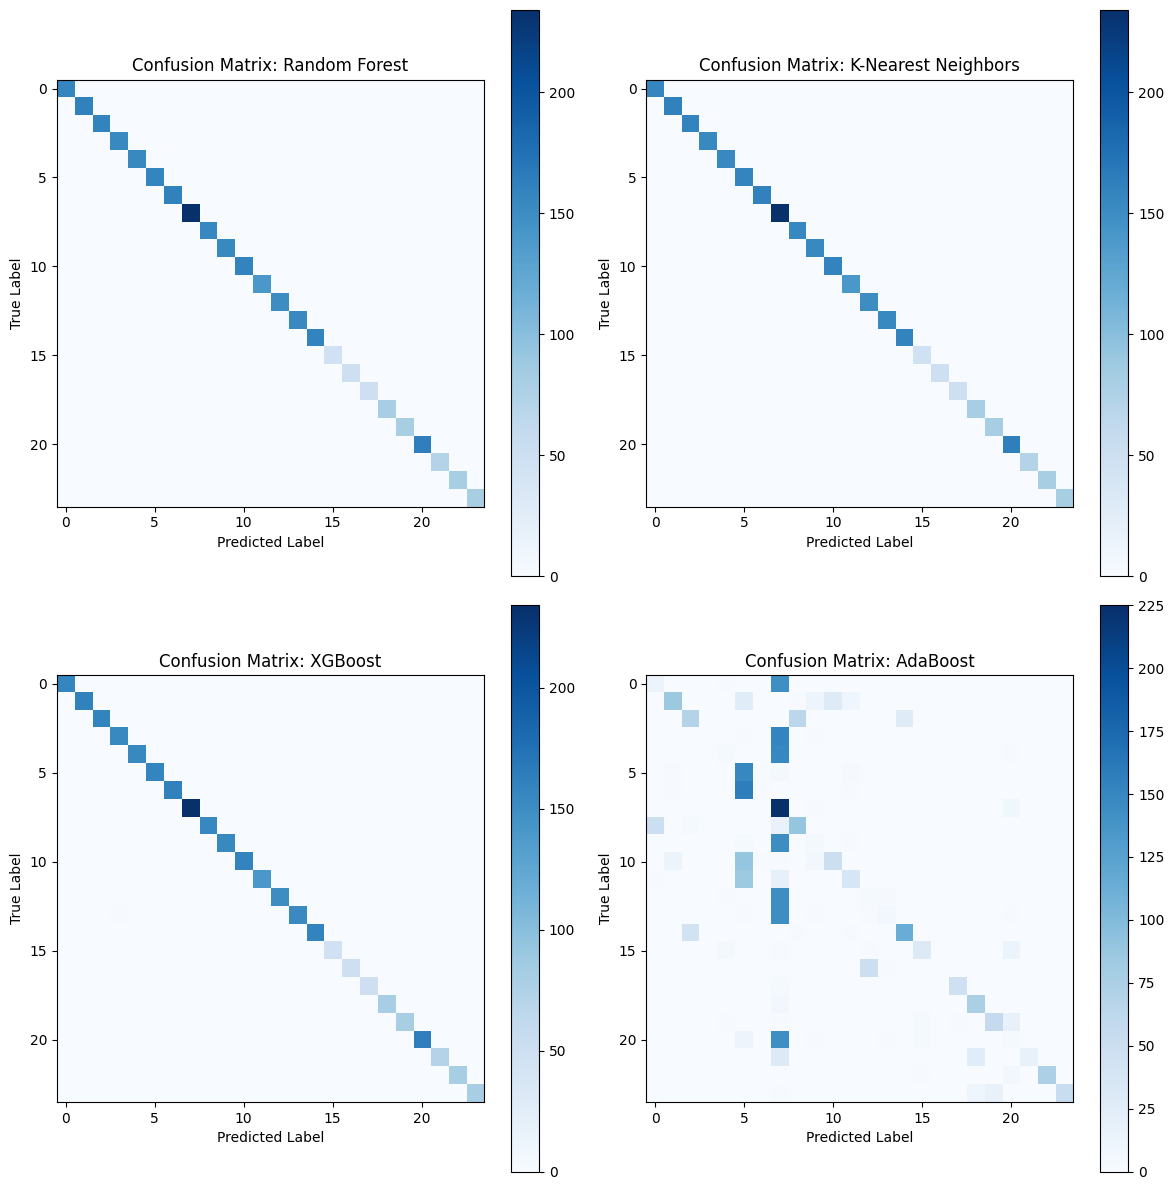

In [36]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f"Confusion Matrix: {model_name}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [16]:
# Load pre-trained machine learning models
rf_clf = joblib.load("random_forest_model.pkl")
knn_clf = joblib.load("knn_model.pkl")
xgb_clf = joblib.load("xgboost_model.pkl")
ada_clf = joblib.load("adaboost_model.pkl")

Gerçek Etiket: apple_6
Random Forest Tahmini: apple_6
KNN Tahmini: apple_6
XGBoost Tahmini: apple_6
AdaBoost Tahmini: apple_hit_1


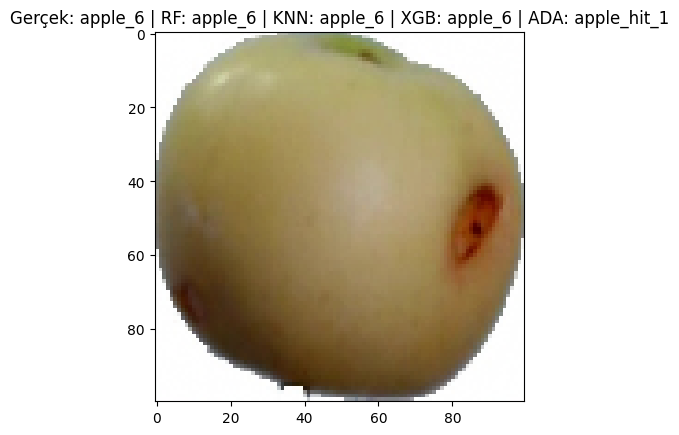

In [40]:
# Test with a random test image
def test_with_random_test_image():
    random_index = random.randint(0, len(test_data) - 1)
    random_image = test_data[random_index]
    true_label = label_encoder.inverse_transform([test_labels_encoded[random_index]])[0]

    predicted_rf = label_encoder.inverse_transform(rf_clf.predict([random_image]))[0]
    predicted_knn = label_encoder.inverse_transform(knn_clf.predict([random_image]))[0]
    predicted_xgb = label_encoder.inverse_transform(xgb_clf.predict([random_image]))[0]
    predicted_ada = label_encoder.inverse_transform(ada_clf.predict([random_image]))[0]

    print(f"Gerçek Etiket: {true_label}")
    print(f"Random Forest Tahmini: {predicted_rf}")
    print(f"KNN Tahmini: {predicted_knn}")
    print(f"XGBoost Tahmini: {predicted_xgb}")
    print(f"AdaBoost Tahmini: {predicted_ada}")

    reshaped_image = scaler.inverse_transform([random_image]).reshape(100, 100, 3).astype(np.uint8)
    plt.imshow(cv2.cvtColor(reshaped_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Gerçek: {true_label} | RF: {predicted_rf} | KNN: {predicted_knn} | XGB: {predicted_xgb} | ADA: {predicted_ada}")
    plt.show()

# Example usage
test_with_random_test_image()

Random Forest Tahmini: apple_red_yellow_1
KNN Tahmini: apple_red_1
XGBoost Tahmini: apple_braeburn_1
AdaBoost Tahmini: apple_red_1


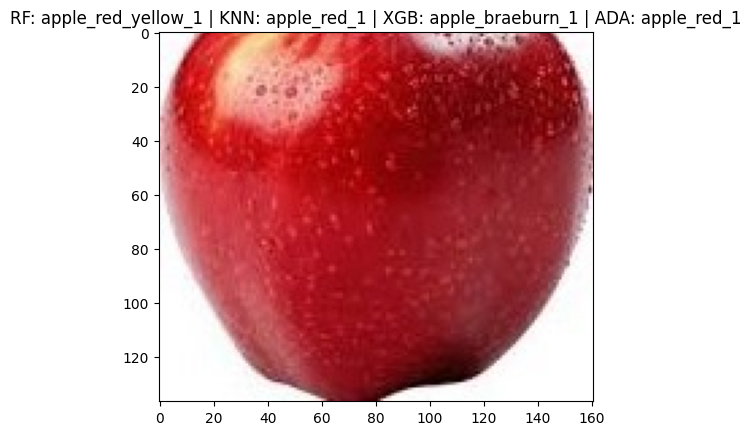

In [29]:
# Test with a user-specified image
def test_with_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Invalid image path.")
        return

    img_resized = cv2.resize(img, image_size).flatten()
    normalized_image = scaler.transform([img_resized])

    predicted_rf = label_encoder.inverse_transform(rf_clf.predict(normalized_image))[0]
    predicted_knn = label_encoder.inverse_transform(knn_clf.predict(normalized_image))[0]
    predicted_xgb = label_encoder.inverse_transform(xgb_clf.predict(normalized_image))[0]
    predicted_ada = label_encoder.inverse_transform(ada_clf.predict(normalized_image))[0]

    print(f"Random Forest Tahmini: {predicted_rf}")
    print(f"KNN Tahmini: {predicted_knn}")
    print(f"XGBoost Tahmini: {predicted_xgb}")
    print(f"AdaBoost Tahmini: {predicted_ada}")

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"RF: {predicted_rf} | KNN: {predicted_knn} | XGB: {predicted_xgb} | ADA: {predicted_ada}")
    plt.show()

# Example usage
test_with_image("fruits-360-original/elma.png")

In [13]:
# Define activation and helper functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def initialize_weights(layer_sizes):
    weights = []
    biases = []
    for i in range(len(layer_sizes) - 1):
        weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.1)
        biases.append(np.zeros((1, layer_sizes[i + 1])))
    return weights, biases

def forward_pass(x, weights, biases):
    activations = []
    z_values = []

    a = x
    for w, b in zip(weights[:-1], biases[:-1]):
        z = np.dot(a, w) + b
        a = sigmoid(z)
        z_values.append(z)
        activations.append(a)

    # Output layer (Softmax)
    z = np.dot(a, weights[-1]) + biases[-1]
    a = softmax(z)
    z_values.append(z)
    activations.append(a)

    return a, activations, z_values

def backward_pass(x, y, weights, biases, activations, z_values, learning_rate):
    m = x.shape[0]
    one_hot_y = np.zeros((m, activations[-1].shape[1]))
    one_hot_y[np.arange(m), y] = 1

    dz = activations[-1] - one_hot_y
    for i in reversed(range(len(weights))):
        dw = np.dot((x if i == 0 else activations[i - 1]).T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m

        weights[i] -= learning_rate * dw
        biases[i] -= learning_rate * db

        if i > 0:
            dz = np.dot(dz, weights[i].T) * sigmoid_derivative(activations[i - 1])

def train_ann(x, y, layer_sizes, epochs, learning_rate):
    weights, biases = initialize_weights(layer_sizes)
    history = {"loss": [], "accuracy": []}

    for epoch in range(epochs):
        output, activations, z_values = forward_pass(x, weights, biases)
        backward_pass(x, y, weights, biases, activations, z_values, learning_rate)

        # Compute loss and accuracy
        loss = -np.mean(np.log(output[np.arange(y.shape[0]), y]))
        accuracy = np.mean(np.argmax(output, axis=1) == y)
        history["loss"].append(loss)
        history["accuracy"].append(accuracy)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

    return weights, biases, history

def predict_ann(x, weights, biases):
    output, _, _ = forward_pass(x, weights, biases)
    return np.argmax(output, axis=1)

In [61]:
# Initialize and train ANN
input_size = train_data.shape[1]
hidden_sizes = [128, 64]
output_size = len(np.unique(train_labels_encoded))
layer_sizes = [input_size] + hidden_sizes + [output_size]

print("Training ANN...")
weights, biases, history = train_ann(train_data, train_labels_encoded, layer_sizes, epochs=250, learning_rate=0.32)


Training ANN...
Epoch 10/250, Loss: 2.9506, Accuracy: 16.18%
Epoch 20/250, Loss: 2.7700, Accuracy: 32.26%
Epoch 30/250, Loss: 2.5721, Accuracy: 43.19%
Epoch 40/250, Loss: 2.3676, Accuracy: 51.18%
Epoch 50/250, Loss: 2.1654, Accuracy: 55.19%
Epoch 60/250, Loss: 1.9735, Accuracy: 58.77%
Epoch 70/250, Loss: 1.7982, Accuracy: 61.80%
Epoch 80/250, Loss: 1.6418, Accuracy: 64.79%
Epoch 90/250, Loss: 1.5035, Accuracy: 68.19%
Epoch 100/250, Loss: 1.3811, Accuracy: 72.06%
Epoch 110/250, Loss: 1.2721, Accuracy: 76.09%
Epoch 120/250, Loss: 1.1746, Accuracy: 79.49%
Epoch 130/250, Loss: 1.0866, Accuracy: 82.88%
Epoch 140/250, Loss: 1.0068, Accuracy: 85.46%
Epoch 150/250, Loss: 0.9337, Accuracy: 87.35%
Epoch 160/250, Loss: 0.8667, Accuracy: 89.10%
Epoch 170/250, Loss: 0.8053, Accuracy: 90.58%
Epoch 180/250, Loss: 0.7491, Accuracy: 91.45%
Epoch 190/250, Loss: 0.6976, Accuracy: 92.14%
Epoch 200/250, Loss: 0.6500, Accuracy: 92.78%
Epoch 210/250, Loss: 0.6063, Accuracy: 93.28%
Epoch 220/250, Loss: 0.5659

In [62]:
# Save trained model using pickle
with open("trained_model.pkl", "wb") as f:
    pickle.dump({"weights": weights, "biases": biases}, f)

print("Model saved successfully.")

Model saved successfully.


In [63]:
# Test ANN
y_pred_ann = predict_ann(test_data, weights, biases)
accuracy = np.mean(y_pred_ann == test_labels_encoded)
print(f"ANN Test Accuracy: {accuracy * 100:.2f}%")


ANN Test Accuracy: 95.47%


In [64]:
# Generate classification report
report = classification_report(test_labels_encoded, y_pred_ann, target_names=label_encoder.classes_)
print(report)

                      precision    recall  f1-score   support

             apple_6       0.84      1.00      0.91       157
    apple_braeburn_1       0.95      1.00      0.98       160
apple_crimson_snow_1       0.99      1.00      1.00       159
      apple_golden_1       0.97      0.99      0.98       154
      apple_golden_2       0.99      1.00      0.99       154
      apple_golden_3       0.95      0.96      0.95       158
apple_granny_smith_1       0.92      1.00      0.96       160
         apple_hit_1       1.00      1.00      1.00       234
   apple_pink_lady_1       1.00      0.99      1.00       156
         apple_red_1       0.93      0.92      0.93       154
         apple_red_2       1.00      0.99      1.00       159
         apple_red_3       1.00      1.00      1.00       140
apple_red_delicios_1       0.99      1.00      0.99       150
  apple_red_yellow_1       0.97      0.90      0.93       154
      apple_rotten_1       1.00      1.00      1.00       159
     ca

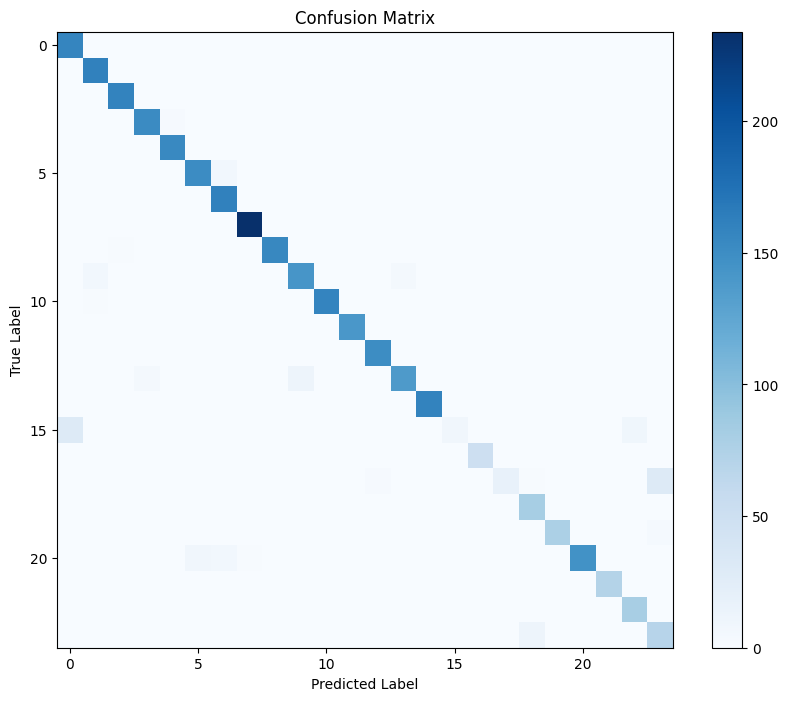

In [65]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, y_pred_ann)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


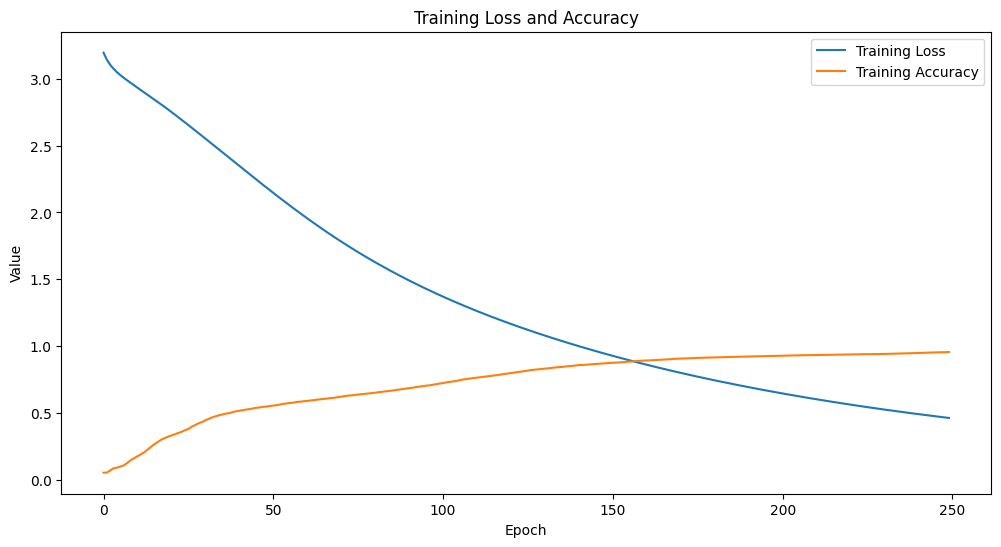

In [66]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["accuracy"], label="Training Accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

In [14]:
# Load trained model from pickle
with open("trained_model.pkl", "rb") as f:
    model_data = pickle.load(f)

weights = model_data["weights"]
biases = model_data["biases"]

Gerçek Etiket: apple_hit_1
ANN Tahmini: apple_hit_1


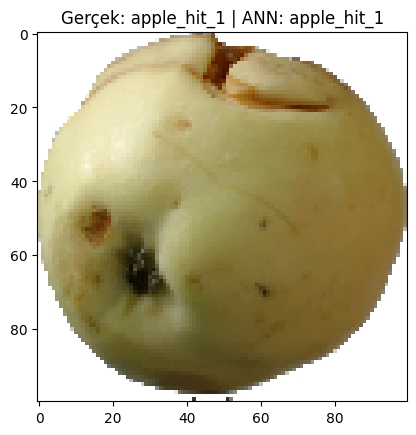

In [19]:
# Test a random image with ANN from saved model
random_index = random.randint(0, len(test_data) - 1)
random_image = scaler.inverse_transform([test_data[random_index]]).reshape(100, 100, 3).astype(np.uint8)
predicted_ann = label_encoder.inverse_transform([predict_ann([test_data[random_index]], weights, biases)[0]])[0]
true_class = label_encoder.inverse_transform([test_labels_encoded[random_index]])[0]

print(f"Gerçek Etiket: {true_class}")
print(f"ANN Tahmini: {predicted_ann}")

plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
plt.title(f"Gerçek: {true_class} | ANN: {predicted_ann}")
plt.show()


In [3]:
image_size = (100, 100)
train_labels = []
train_data = []

for fruit_dir in os.listdir(training_dir):
    fruit_path = os.path.join(training_dir, fruit_dir)
    if os.path.isdir(fruit_path):
        for img_name in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, image_size)
                train_data.append(img_resized)
                train_labels.append(fruit_dir)

validation_labels = []
validation_data = []

for fruit_dir in os.listdir(validation_dir):
    fruit_path = os.path.join(validation_dir, fruit_dir)
    if os.path.isdir(fruit_path):
        for img_name in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, image_size)
                validation_data.append(img_resized)
                validation_labels.append(fruit_dir)


In [4]:
# Encode labels to numeric values
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)

In [5]:
# Normalize data
train_data = np.array(train_data, dtype=np.float32) / 255.0
validation_data = np.array(validation_data, dtype=np.float32) / 255.0

In [6]:
# One-hot encoding labels
train_labels_categorical = to_categorical(train_labels_encoded)
validation_labels_categorical = to_categorical(validation_labels_encoded)

In [7]:
# CNN Model
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn_model()

c:\Users\90544\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded)
history = model.fit(train_data, train_labels_categorical, epochs=10, validation_data=(validation_data, validation_labels_categorical), batch_size=32, class_weight=dict(enumerate(class_weights)))


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 47s 227ms/step - accuracy: 0.3886 - loss: 1.9700 - val_accuracy: 0.9663 - val_loss: 0.1431
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 43s 218ms/step - accuracy: 0.8870 - loss: 0.2800 - val_accuracy: 0.9679 - val_loss: 0.0772
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 43s 221ms/step - accuracy: 0.9295 - loss: 0.1834 - val_accuracy: 0.9843 - val_loss: 0.0404
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 43s 219ms/step - accuracy: 0.9440 - loss: 0.1614 - val_accuracy: 0.9990 - val_loss: 0.0102
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 43s 219ms/step - accuracy: 0.9663 - loss: 0.0795 - val_accuracy: 0.9913 - val_loss: 0.0279
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 44s 224ms/step - accuracy: 0.9682 - loss: 0.0809 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 44s 223ms/step - accuracy: 0.9799 - loss: 0.0501 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 56s 288ms/step - accuracy: 0.9796 - loss: 0

In [9]:
# Save the model
model.save("CNN_model.h5")

In [10]:
# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_data, validation_labels_categorical)
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9993 - loss: 0.0058
Validation Loss: 0.006342161446809769, Validation Accuracy: 0.9987154603004456


In [11]:
# Generate classification report
predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)
print(classification_report(validation_labels_encoded, predicted_labels, target_names=label_encoder.classes_))


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step
                      precision    recall  f1-score   support

             apple_6       1.00      1.00      1.00       158
    apple_braeburn_1       1.00      1.00      1.00       160
apple_crimson_snow_1       1.00      1.00      1.00       159
      apple_golden_1       0.99      1.00      0.99       154
      apple_golden_2       1.00      1.00      1.00       154
      apple_golden_3       1.00      1.00      1.00       158
apple_granny_smith_1       1.00      1.00      1.00       160
         apple_hit_1       1.00      1.00      1.00       234
   apple_pink_lady_1       1.00      1.00      1.00       156
         apple_red_1       0.99      1.00      0.99       155
         apple_red_2       1.00      0.99      0.99       159
         apple_red_3       1.00      1.00      1.00       141
apple_red_delicios_1       1.00      1.00      1.00       150
  apple_red_yellow_1       1.00      0.99      0.99       154
      apple_rotten_1       1.

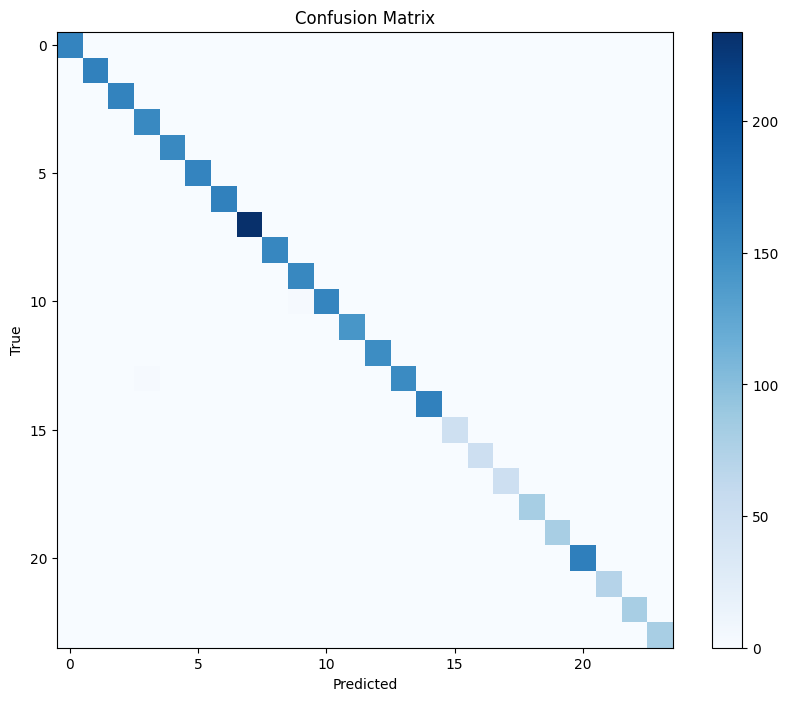

In [12]:
# Confusion matrix
conf_matrix = confusion_matrix(validation_labels_encoded, predicted_labels)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

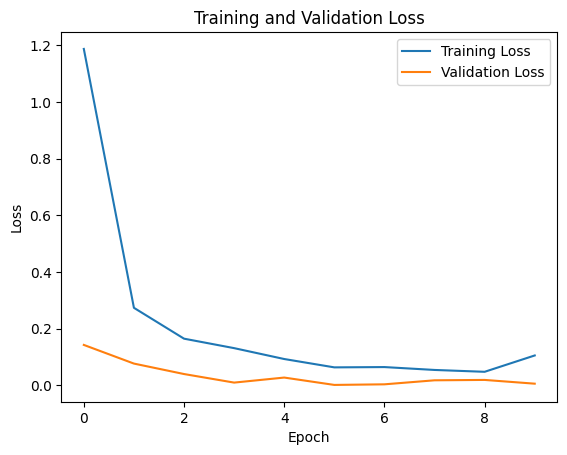

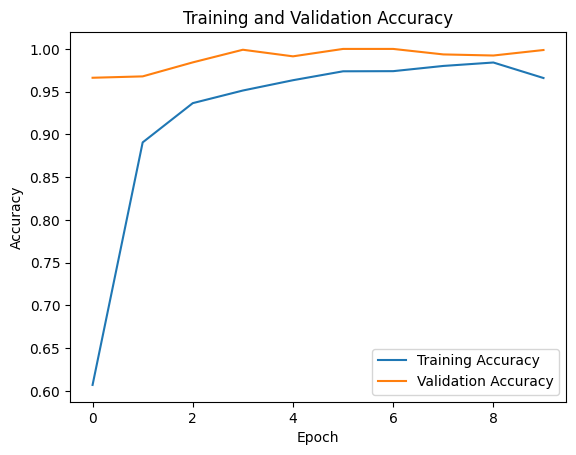

In [14]:
# Training/Validation Loss and Accuracy Graphs
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
True Class: apple_red_2, Predicted Class: apple_red_2


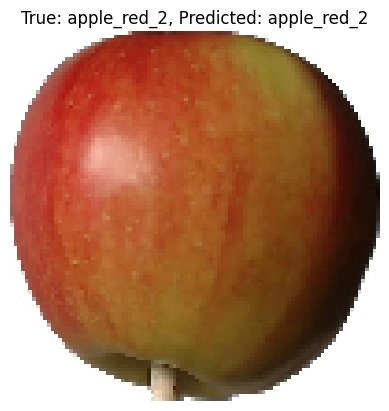

In [30]:
# Test a random image from saved model
random_class = random.choice(os.listdir(testing_dir))
random_image_name = random.choice(os.listdir(os.path.join(testing_dir, random_class)))
random_image_path = os.path.join(testing_dir, random_class, random_image_name)
random_image = cv2.imread(random_image_path)
random_image_resized = cv2.resize(random_image, image_size)
random_image_scaled = random_image_resized / 255.0
random_image_scaled = np.expand_dims(random_image_scaled, axis=0)

loaded_model = tf.keras.models.load_model("CNN_model.h5")
prediction = loaded_model.predict(random_image_scaled)
predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
true_class = random_class

print(f"True Class: {true_class}, Predicted Class: {predicted_class[0]}")

plt.imshow(cv2.cvtColor(random_image_resized, cv2.COLOR_BGR2RGB))
plt.title(f"True: {true_class}, Predicted: {predicted_class[0]}")
plt.axis('off')
plt.show()
